In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import os, sys
import cftime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler

2025-07-31 13:24:50.657057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 13:24:50.679710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In [2]:
def read_csv(file_path, filename, varname):
    """
    Reads a CSV file, skips the first line and converts into into xarray.
    """
    ds = pd.read_csv(file_path+filename, skiprows=1, header=None, names=['time', varname], na_values=['NaN',-9999])
    ds['time'] = pd.to_datetime(ds['time'], format='%Y-%m-%d')

    ds = ds.set_index('time')
    ds = ds.to_xarray()
    ds['time'] = ds['time'].astype('datetime64[ns]')
    ds[varname] = ds[varname].astype('float32')

    return ds

def read_csv2(filepath):
    """
    Reads a CSV file and converts it to an xarray Dataset.
    """

    df = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    
    df.columns = ['time', 'q']
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
    df.set_index('time', inplace=True)
    ds = df.to_xarray()
    
    return ds

def anom(xarr):
    #monthly mean anomaly (No-detrened)

    xarr_clm = xarr.groupby('time.month').mean('time')
    xarr_ano = xarr.groupby('time.month') - xarr_clm
    return xarr_ano, xarr_clm

In [3]:
path = '/home/amnd25/Desktop/Milano/Test_CDP_PhD/'

dmi = read_csv(path,'dmi.had.long.csv','dmi')
mei = read_csv(path,'mei.ext.long.csv','mei') # multivariate ENSO index
nao = read_csv(path,'nao.long.csv','nao')
nino3 = read_csv(path,'nino3.long.anom.csv','nino3')
nino4 = read_csv(path,'nino4.long.anom.csv','nino4')
nino12 = read_csv(path,'nino12.long.anom.csv','nino12')
nino34 = read_csv(path,'nino34.long.anom.csv','nino34')
pdo = read_csv(path,'pdo.timeseries.sstens.csv','pdo') # Pacific Decadal Oscillation
soi = read_csv(path,'soi.long.csv','soi') # Southern Oscillation Index
tsa = read_csv(path,'tsa.long.csv','tsa') # Tropical Southern Atlantic

data_names = ['dmi', 'mei', 'nao', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi', 'tsa'] # 10 climate indices
data_list =[dmi, mei, nao, nino3, nino4, nino12, nino34, pdo, soi, tsa]

In [4]:
streamflow = read_csv2(path+'Zambezi_at_BigTree_VicFalls_obs_discharge.txt')

streamflow_anom, streamflow_clm = anom(streamflow.q)

In [5]:
streamflow.q

<xarray.DataArray 'q' (time: 34252)> Size: 274kB
array([ 100.,  100.,  100., ..., 1671., 1635., 1587.])
Coordinates:
  * time     (time) datetime64[ns] 274kB 1924-10-01 1924-10-02 ... 2018-07-11

In [6]:
data_names = ['nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi']
data_list =[nino3, nino4, nino12, nino34, pdo, soi]
data_list_time_cropped = [ds.sel(time=slice('1924-10-01', '2018-07-11')) for ds in data_list]

## Modello

In [7]:
window_size = 36
lag = 3
forecast_horizon = 1

monthly_streamflow = streamflow.q.resample(time='MS').mean('time')
monthly_streamflow = monthly_streamflow.dropna('time')

optimal_lags = {
    'nino3': 2,
    'nino4': 1,
    'nino12': 2,
    'nino34': 2,
    'pdo': 4,
    'soi': 4,}

climate_matrix = [] 

for nome, ds in zip(data_names, data_list_time_cropped):
    index_monthly = ds[nome].resample(time='MS').mean('time') # Make sure that they are monthly
    index_monthly = index_monthly.shift(time=optimal_lags[nome])  # Shift the index according to the optimal lag
    index_monthly = index_monthly.dropna('time') # Align with streamflow
    climate_matrix.append(index_monthly) 

climate_concat = xr.concat(climate_matrix, dim='variable') # Concatenate all climate indices along a new dimension
climate_concat['variable'] = data_names
climate_df = climate_concat.transpose('time', 'variable').to_pandas() # Transpose to have time as index and variables as columns
# We transpose because we want to align the climate indices with the streamflow time series
climate_df.columns = data_names

streamflow_series = monthly_streamflow.to_pandas()
climate_df, streamflow_aligned = climate_df.align(streamflow_series, join='inner', axis=0) # join='inner' to keep only the common dates

In [8]:
def create_dataset(features, target, window_size=36, horizon=3):
    X, y = [], []
    for i in range(len(features) - window_size - horizon + 1):
        X.append(features[i:i+window_size])
        y.append(target[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y)

In [9]:
df = pd.concat([streamflow_aligned, climate_df], axis=1)
df = df.dropna()

df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

# Assumiamo che df abbia come prima colonna il target "streamflow"
all_features_array = df.iloc[:, 1:].values  # Tutte le variabili climatiche (es. nino3, pdo, etc.)
streamflow_array = df.iloc[:, 0].values     # Target: la serie della portata

X, y = create_dataset(all_features_array, streamflow_array, window_size, horizon=3)

print("X shape:", X.shape)  # (samples, 24, num_features)
print("y shape:", y.shape)  # (samples, 3)

print(df.columns)
print("Numero di feature (escluse le target):", df.shape[1] - 1)


X shape: (1084, 36, 8)
y shape: (1084, 3)
Index(['q', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi', 'month_sin',
       'month_cos'],
      dtype='object')
Numero di feature (escluse le target): 8


### Splitting training/testing

In [10]:
# Ensure dates has the same length as X and y
# If dates is too short, pad with None; if too long, slice
dates = df.index[window_size + lag:len(df) - forecast_horizon + 1].tolist()
if len(dates) < len(X):
    dates_aligned = list(dates) + [None] * (len(X) - len(dates))
else:
    dates_aligned = dates[:len(X)]

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates_aligned, test_size=0.2, shuffle=False)

### Standardization

In [11]:
# Standardizza ogni feature separatamente
scalers = []
X_train_scaled = np.zeros_like(X_train)
X_test_scaled = np.zeros_like(X_test)

for i in range(X.shape[2]):  # per ogni feature
    scaler = StandardScaler()
    X_train_feat = X_train[:, :, i].reshape(-1, 1)
    scaler.fit(X_train_feat)

    X_train_scaled[:, :, i] = scaler.transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train[:, :, i].shape)
    X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test[:, :, i].shape)
    
    scalers.append(scaler)

# Standardizza il target y (t+1, t+2, t+3)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


### Model definition

In [12]:
# Positional Encoding
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    # apply sin to even indices in the array; cos to odd indices
    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = pos_encoding[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer Block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation='relu'), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Costruiamo il modello
def build_transformer_model(window_size, n_features, embed_dim=64, num_heads=4, ff_dim=128, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(window_size, n_features))
    # Proiettiamo le features in embedding dim
    x = Dense(embed_dim)(inputs)
    
    # Aggiungiamo Positional Encoding
    x += positional_encoding(window_size, embed_dim)
    
    # Transformer block
    #x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    for _ in range(2):  # Cambia il numero per provare più strati
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    #x = GlobalAveragePooling1D()(x)

    # Output per 3 mesi in futuro (t+1, t+2, t+3)
    outputs = Dense(3)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
  # Huber loss for robustness to outliers
    model.compile(optimizer='adam', loss=Huber(delta=1.0))  # Huber loss for robustness to outliers
    return model


In [13]:
#model = build_transformer_model(window_size=36, n_features=X.shape[2])
model = build_transformer_model(window_size=36, n_features=X_train.shape[2],
                                 embed_dim=128, num_heads=4, ff_dim=256)

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 36, 128)        │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 36, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 36, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 36, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,019 (2.53 MB)

 Trainable params: 662,019 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.7579 - val_loss: 0.3471 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2743 - val_loss: 0.1596 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1622 - val_loss: 0.1559 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1660 - val_loss: 0.1424 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1432 - val_loss: 0.1794 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1362 - val_loss: 0.1695 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1284 - val_loss: 0.1827 - learning_rate: 0.0010
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1097 - val_loss: 0.1484 - learning_rate: 0.0010
Epoch 9/100
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1353
Epoch 9: ReduceLROnPlateau reducing learning rate to 

In [14]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)  # Ritorniamo alle unità originali

y_true = y_test.reshape(-1, 3)  # Anche y_test ha shape flat, lo rimettiamo a (n_samples, 3)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

for i, month in enumerate(['t+1', 't+2', 't+3']):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    print(f"{month} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")


t+1 - RMSE: 579.89, MAE: 358.93
t+2 - RMSE: 626.21, MAE: 358.04
t+3 - RMSE: 672.18, MAE: 389.48


In [16]:
for i, month in enumerate(['t+1', 't+2', 't+3']):
    y_t = y_true[:, i]
    y_p = y_pred[:, i]

    q10 = np.percentile(y_t, 10)
    q90 = np.percentile(y_t, 90)

    extreme_mask = (y_t < q10) | (y_t > q90)
    rmse_extreme = np.sqrt(mean_squared_error(y_t[extreme_mask], y_p[extreme_mask]))
    print(f"{month} - RMSE on extremes (<10% or >90%): {rmse_extreme:.2f}")


t+1 - RMSE on extremes (<10% or >90%): 1012.07
t+2 - RMSE on extremes (<10% or >90%): 1015.83
t+3 - RMSE on extremes (<10% or >90%): 1063.46


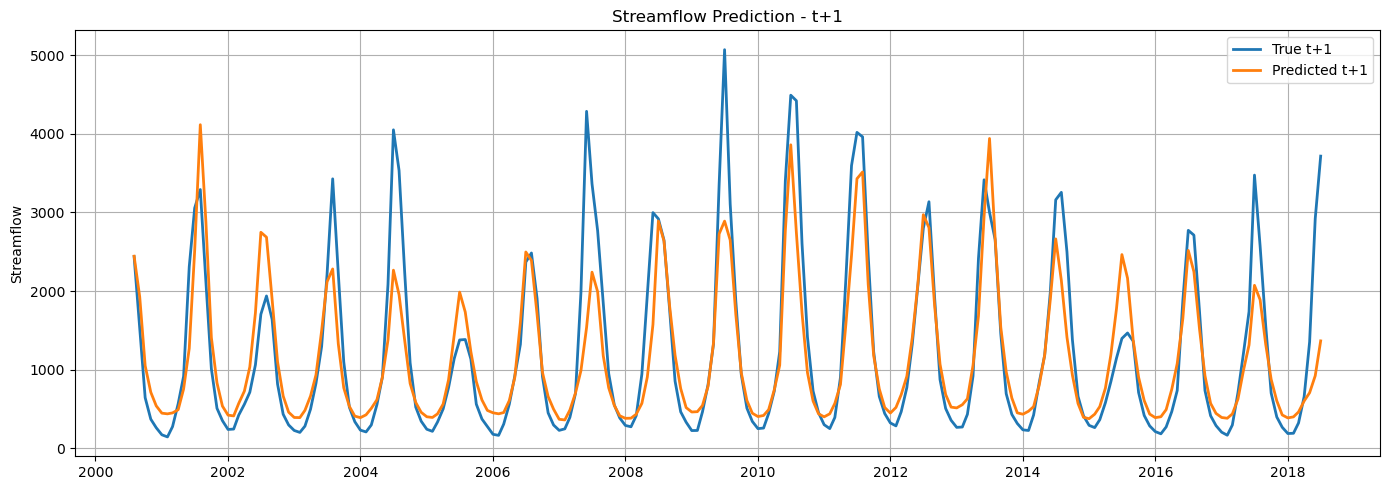

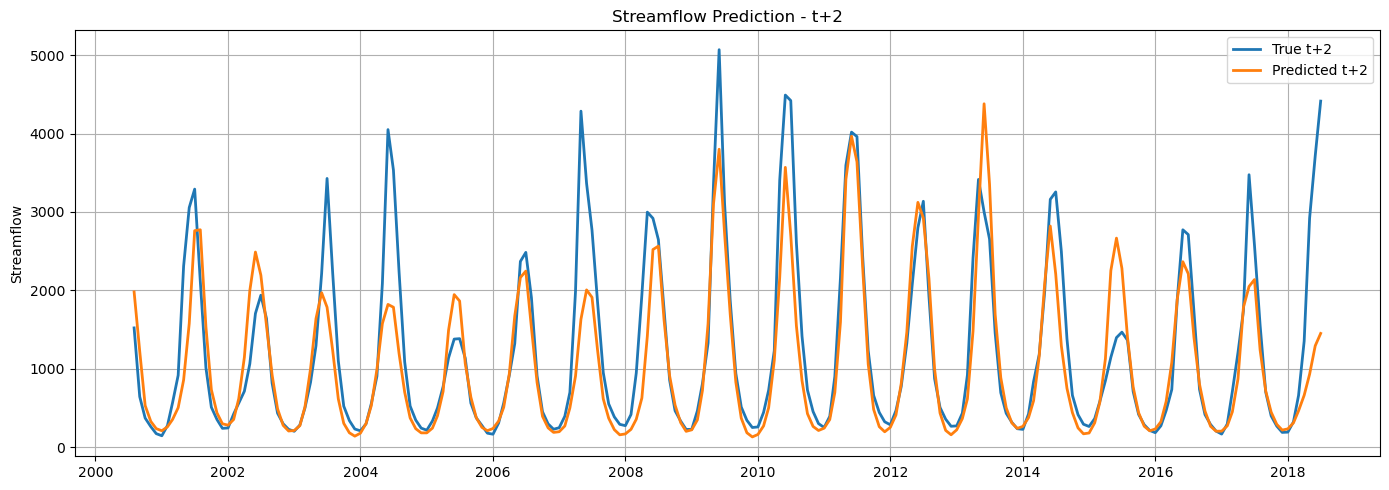

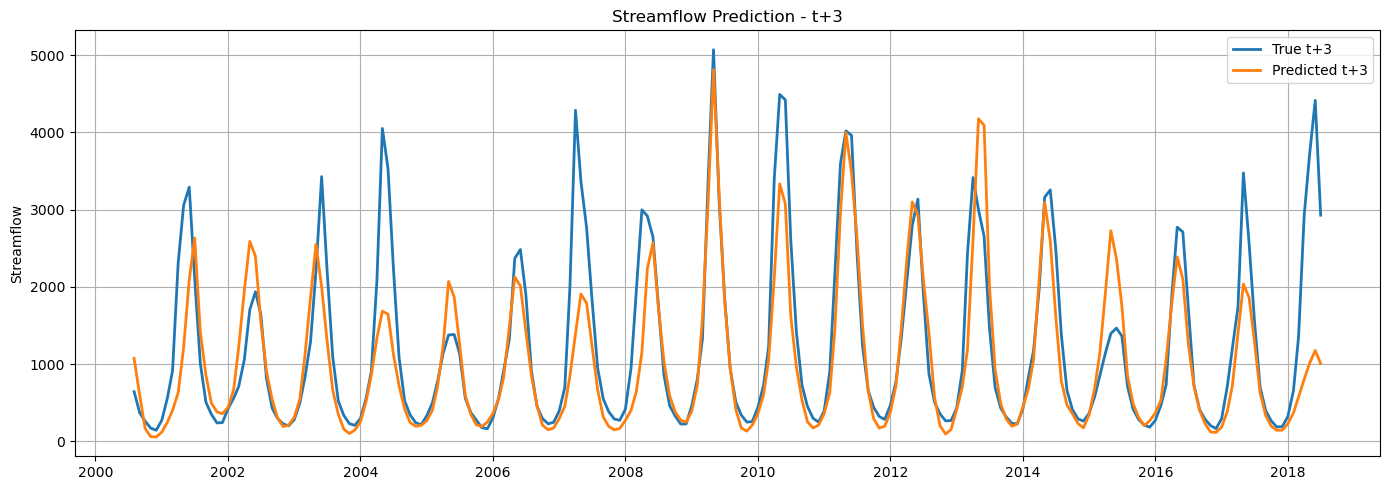

In [17]:

# Scegli quale mese prevedere: t+1 = 0, t+2 = 1, t+3 = 2
month_idx = 0  
month_label = ['t+1', 't+2', 't+3'][month_idx]

plt.figure(figsize=(14, 5))
plt.plot(dates_test, y_true[:, month_idx], label=f'True t+{month_idx + 1}', linewidth=2)
plt.plot(dates_test, y_pred[:, month_idx], label=f'Predicted t+{month_idx + 1}', linewidth=2)
plt.ylabel("Streamflow")
plt.title(f"Streamflow Prediction - t+{month_idx + 1}")
plt.legend()
plt.grid(True)
plt.tight_layout()

month_idx = 1
plt.figure(figsize=(14, 5))
plt.plot(dates_test, y_true[:, month_idx], label=f'True t+{month_idx + 1}', linewidth=2)
plt.plot(dates_test, y_pred[:, month_idx], label=f'Predicted t+{month_idx + 1}', linewidth=2)
plt.ylabel("Streamflow")
plt.title(f"Streamflow Prediction - t+{month_idx + 1}")
plt.legend()
plt.grid(True)
plt.tight_layout()

month_idx = 2
plt.figure(figsize=(14, 5))
plt.plot(dates_test, y_true[:, month_idx], label=f'True t+{month_idx + 1}', linewidth=2)
plt.plot(dates_test, y_pred[:, month_idx], label=f'Predicted t+{month_idx + 1}', linewidth=2)
plt.ylabel("Streamflow")
plt.title(f"Streamflow Prediction - t+{month_idx + 1}")
plt.legend()
plt.grid(True)
plt.tight_layout()

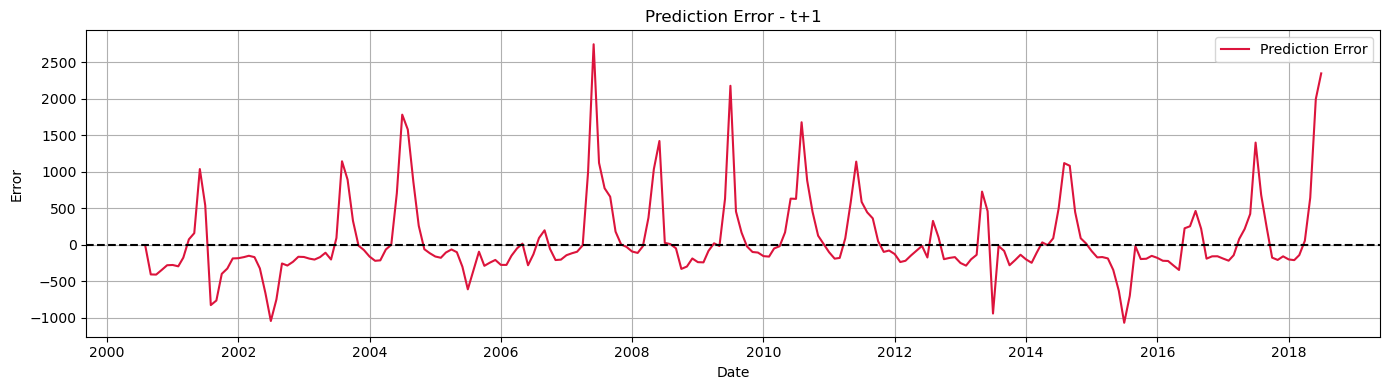

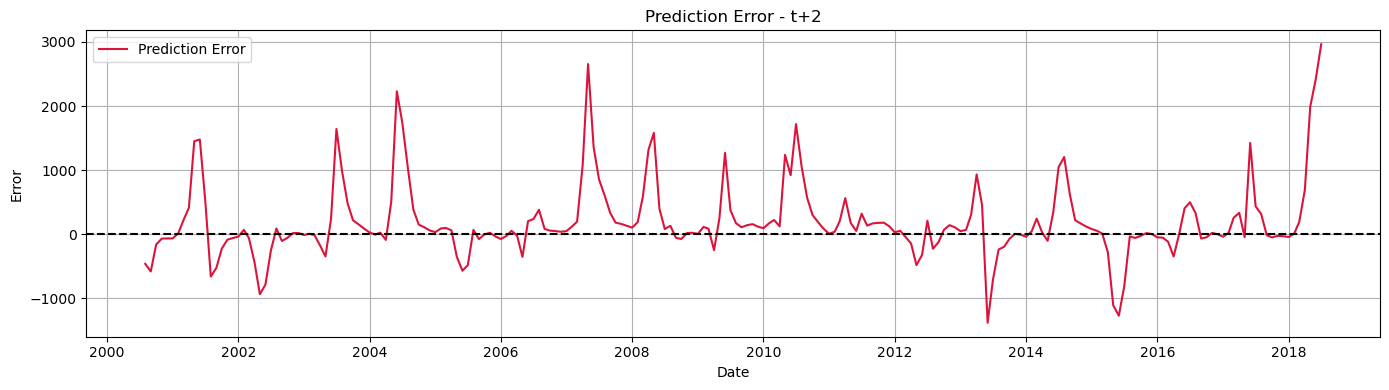

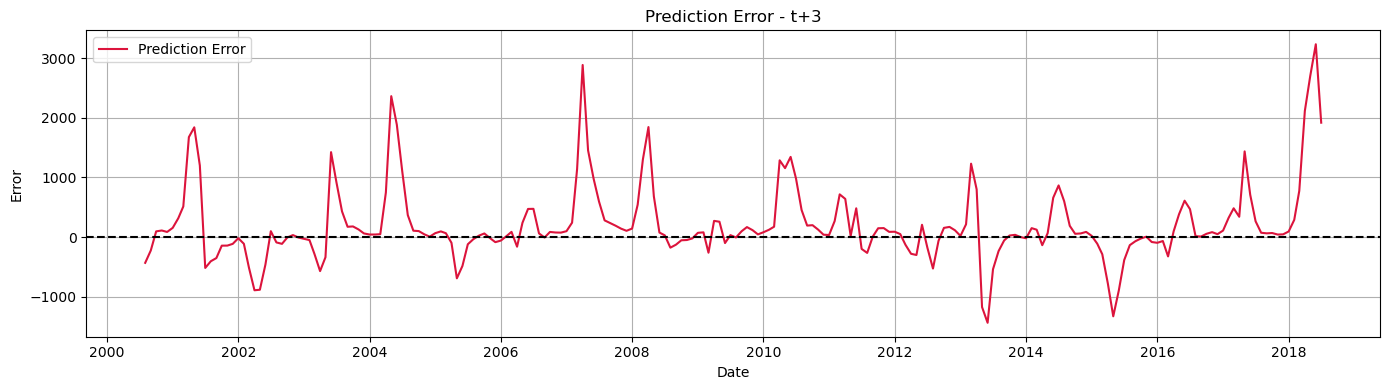

In [18]:
month_idx = 0
errors = y_true[:, month_idx] - y_pred[:, month_idx]

plt.figure(figsize=(14, 4))
plt.plot(dates_test, errors, label='Prediction Error', color='crimson')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title(f'Prediction Error - t+{month_idx + 1}')
plt.grid(True)
plt.tight_layout()
plt.legend()

month_idx = 1
errors = y_true[:, month_idx] - y_pred[:, month_idx]

plt.figure(figsize=(14, 4))
plt.plot(dates_test, errors, label='Prediction Error', color='crimson')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title(f'Prediction Error - t+{month_idx + 1}')
plt.grid(True)
plt.tight_layout()
plt.legend()

month_idx = 2
errors = y_true[:, month_idx] - y_pred[:, month_idx]

plt.figure(figsize=(14, 4))
plt.plot(dates_test, errors, label='Prediction Error', color='crimson')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title(f'Prediction Error - t+{month_idx + 1}')
plt.grid(True)
plt.tight_layout()
plt.legend()



🔵 t+1 EXTREME EVALUATION
10th percentile threshold: 243.96
90th percentile threshold: 3075.63
Mean Absolute Error (low flows)  : 210.332
Mean Absolute Error (high flows) : 1203.753
Mean Absolute Error (overall)    : 358.929


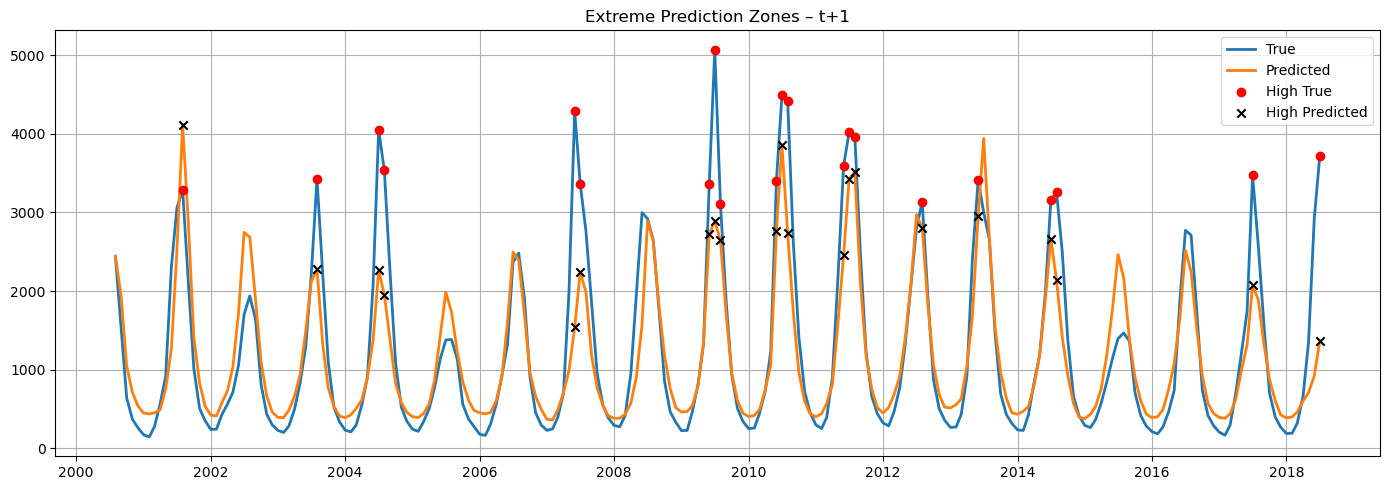


🔵 t+2 EXTREME EVALUATION
10th percentile threshold: 243.96
90th percentile threshold: 3075.63
Mean Absolute Error (low flows)  : 36.886
Mean Absolute Error (high flows) : 1153.342
Mean Absolute Error (overall)    : 358.036


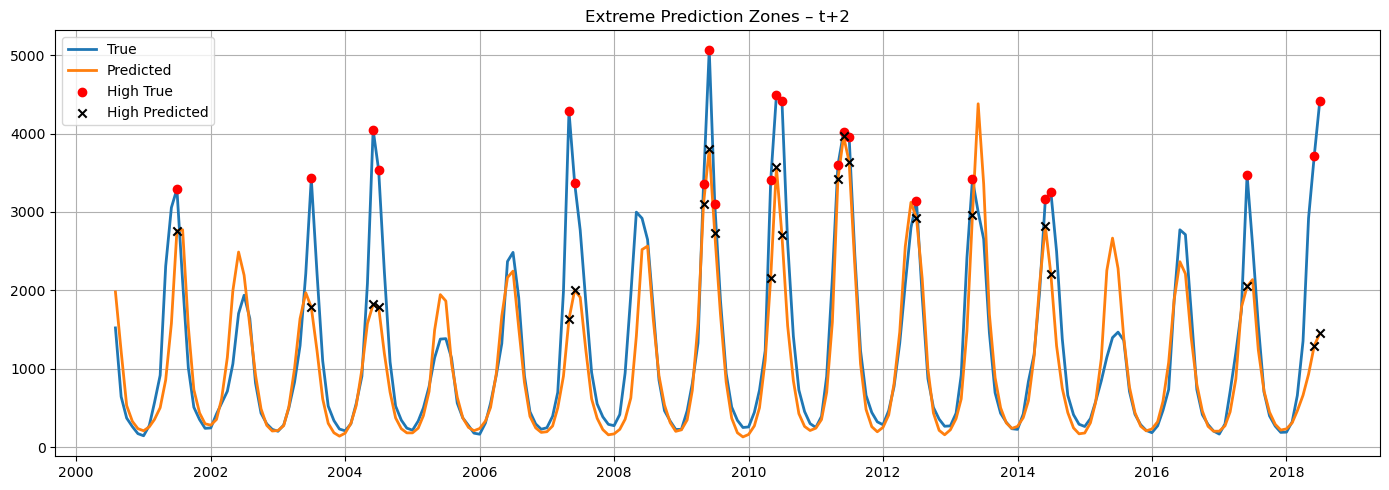


🔵 t+3 EXTREME EVALUATION
10th percentile threshold: 243.96
90th percentile threshold: 3075.63
Mean Absolute Error (low flows)  : 55.430
Mean Absolute Error (high flows) : 1176.983
Mean Absolute Error (overall)    : 389.485


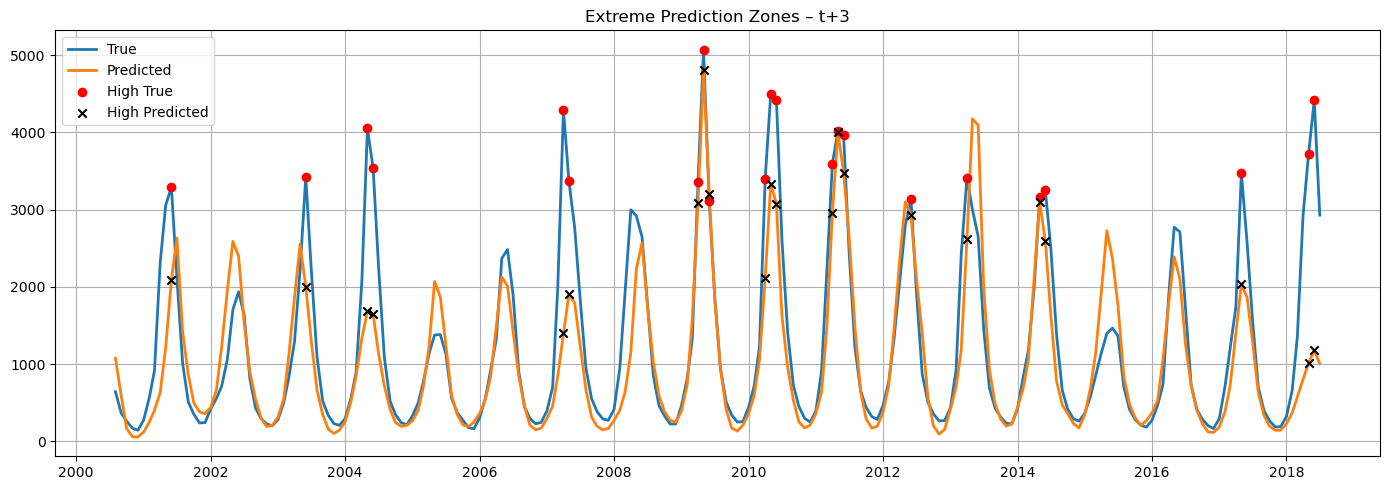

In [19]:
dates_test_np = np.array(dates_test)

for month_idx in range(3):
    # Estremi: definizione dei quantili
    low_thresh = np.percentile(y_true[:, month_idx], 10)
    high_thresh = np.percentile(y_true[:, month_idx], 90)

    # Maschere per condizioni estreme
    low_mask = y_true[:, month_idx] < low_thresh
    high_mask = y_true[:, month_idx] > high_thresh

    # Errori relativi
    low_errors = np.abs(y_pred[:, month_idx][low_mask] - y_true[:, month_idx][low_mask])
    high_errors = np.abs(y_pred[:, month_idx][high_mask] - y_true[:, month_idx][high_mask])
    all_errors = np.abs(y_pred[:, month_idx] - y_true[:, month_idx])

    # --- PRINT METRICHE ---
    print(f"\n🔵 t+{month_idx+1} EXTREME EVALUATION")
    print(f"10th percentile threshold: {low_thresh:.2f}")
    print(f"90th percentile threshold: {high_thresh:.2f}")
    print(f"Mean Absolute Error (low flows)  : {low_errors.mean():.3f}")
    print(f"Mean Absolute Error (high flows) : {high_errors.mean():.3f}")
    print(f"Mean Absolute Error (overall)    : {all_errors.mean():.3f}")

    # --- PLOT ---
    plt.figure(figsize=(14, 5))
    plt.plot(dates_test, y_true[:, month_idx], label='True', linewidth=2)
    plt.plot(dates_test, y_pred[:, month_idx], label='Predicted', linewidth=2)
    plt.scatter(
        dates_test_np[high_mask], y_true[:, month_idx][high_mask],
        color='red', label='High True', zorder=5
    )
    plt.scatter(
        dates_test_np[high_mask], y_pred[:, month_idx][high_mask],
        color='black', label='High Predicted', zorder=5, marker='x'
    )
    plt.title(f'Extreme Prediction Zones – t+{month_idx+1}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
